In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque


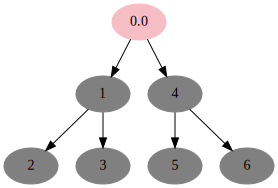

In [2]:
from distributions import Categorical
from mouselab import MouselabEnv
env = MouselabEnv(height=2, reward=Categorical([-1, 1]), cost=0.1)
env.render()

# Regress to optimal policy

In [15]:
from exact import solve, hash_tree
Q, V, pi, info = solve(env)
V(env.init)

0.8999999999999999

In [5]:
from toolz import memoize
   
def regression_data():
    """Returns features and Q* for all(*) state-action pairs in an env.
    
    (*) the state space is reduced by treating symmetric states as one.
    """
#     Q, V, pi, info = solve(env)
    data = []
    @memoize(key=lambda args, kwargs: hash_tree(env, args[0]))
    def rec(s):
        for a in env.actions(s):
            if a == env.term_action: continue
            for p, s1, r in env.results(s, a):
                data.append({
                    'features': click_features(s, a),
                    'state': s,
                    'action': a,
                    'q_star': Q(s, a)
                })
                rec(s1)
    rec(env.init)
    return pd.DataFrame(data)

df = regression_data()

In [6]:
from sklearn.linear_model import LinearRegression
X = np.stack(df.features)
model = LinearRegression().fit(X, df.q_star)

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


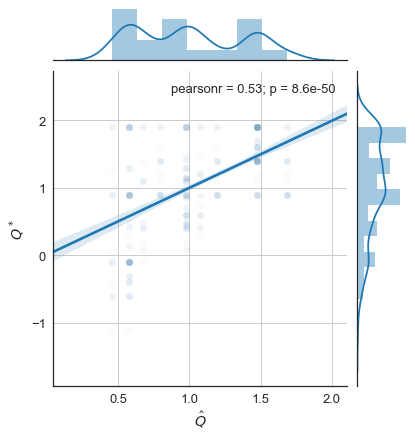

In [7]:
sns.jointplot(model.predict(X), df.q_star, kind='reg',
              joint_kws=dict(scatter_kws=dict(alpha=0.01)))
plt.grid()
plt.ylabel(r'$Q^*$')
plt.xlabel(r'$\hat{Q}$')

# Softmax-Q policy

In [3]:
from agents import Agent
from evaluation import get_util
from human_model import *
from model_utils import *
from policies import RandomPolicy, FixedPlanPolicy, LiederPolicy

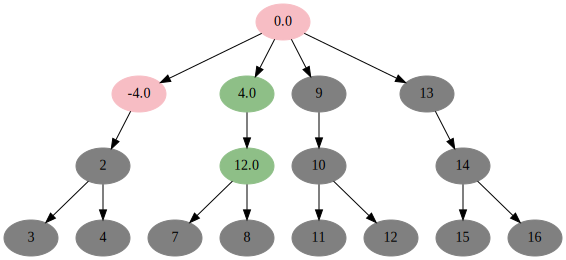

In [4]:
env = make_env(1.25)
env.reset()
for a in [1, 5, 6,]:
    env.step(a)
env.render()

In [5]:
print(action_features(env, env._state, 9).round(3))
print(action_features(env, env._state, 11).round(3))

[  0.      1.      0.     17.172   0.      0.     17.172   0.   ]
[  0.      1.      0.     17.172   0.      0.      0.      0.   ]


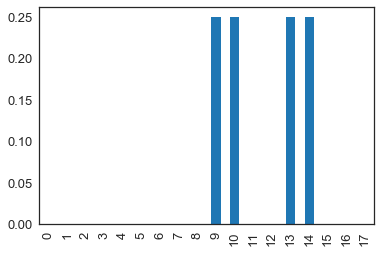

In [6]:
from human_model import *
agent = Agent()
theta = np.ones(8)
pol = HumanPolicy(theta=theta, temp=1)
agent.register(env)
agent.register(pol)
pd.Series(pol.action_distribution(env._state)).plot.bar()

# Simulate experiment

In [7]:
from analysis_utils import *
df, pdf = load('1.8')
COSTS = pdf.info_cost.unique()

def load_envs():
    envs = {}
    for cost in pdf.info_cost.unique():
        with open(f'exp-data/rewards_{cost:.2f}.json') as f:
            d = json.load(f)
            for trial in concatv(d['train'], d['test']):
                envs[trial['trial_id']] = make_env(cost, ground_truth=trial['stateRewards'])
    return envs
    
envs = load_envs()

In [8]:
cost = 1.25

def get_human(cost, seed=None):
    if seed is not None:
        np.random.seed(seed)
    env = make_env(cost)
    return HumanPolicy.optimize([env] * 100, n_calls=100)

results = Parallel(5)(delayed(get_human)(cost, seed) 
                       for cost in [1.25] 
                       for seed in range(5))
# human = dict(zip(COSTS, results))


BO: [ 1.     5.     1.    -0.101  1.     1.     0.441  1.   ] -> 13.645 in 659 sec
BO: [ 1.     1.189  1.     0.338  1.    -1.     0.504  0.706] -> 14.06 in 667 sec
BO: [ 1.     5.    -1.     0.21   1.     0.468  0.312  1.   ] -> 14.53 in 668 sec
BO: [ 1.    -4.919 -1.     1.     1.    -1.     0.087  1.   ] -> 13.785 in 701 sec
BO: [ 1.     5.     0.707  0.557  1.     0.627  0.32   1.   ] -> 14.082 in 710 sec


In [13]:
label = Labeler()
def simulate(policy, envs, seed='-1'):
    agent = Agent()
    agent.register(ENV)
    agent.register(policy)
    for trial_id, env in envs.items():
        agent.register(env)
        trace = agent.run_episode()
        for s, a in zip(trace['states'], trace['actions']):
            yield {'pid': seed, 'cost': abs(env.cost), 'trial_id': trial_id,
                   'state': label(s), 'action': a}
            

sdf = pd.DataFrame(list(concat(simulate(pol, envs, seed) 
                          for seed, pol in zip(range(5), results))))
data = sdf.query('cost == 1.25')

In [56]:
idf = pd.DataFrame(simulate(inferred_pol, envs)).query('cost == 1.25')

In [60]:
data.query('pid == 0').shape

(136, 5)

In [58]:
idf.shape

(137, 5)

# Fit human data

In [459]:
from analysis_utils import load
from model_utils import *
from toolz import *
from human_model import action_features

label = Labeler()
def expand():
    for i, row in df.iterrows():
        for s, a in zip(row.states, concatv(row.clicks, [ENV.term_action])):
            yield {'pid': row.pidx, 'cost': row.info_cost, 'pr_type': row.pr_type,
                   'state': label(parse_state(s)), 'action': a, 'trial_id': row.trial_id}

data = pd.DataFrame(expand())
data.head()

,action,cost,pid,pr_type,state,trial_id
0,1,1.25,0,none,0,8969
1,17,1.25,0,none,1,8969
2,5,1.25,0,none,0,9359
3,9,1.25,0,none,2,9359
4,1,1.25,0,none,3,9359


Likelihood:
$$p(D \mid \theta) = \prod_i^N p(a_i \mid s_i; \theta)$$

Softmax Q policy:
$$p(a \mid s; \theta) = \frac{\exp \{ Q(s, a; \theta) \} }{ \sum_{a'} \exp \{ Q(s, a'; \theta) \} }$$

Linear regression Q:
$$Q(s, a; \theta) = \theta^\top \phi(s, a)$$

Before performing inference, we precompute the features, storing them in a 3d tensor.
`phi[s, a, f]` will give the value $\phi(s, a)_f$


In [18]:
phi = np.array([[action_features(env, s, a) for a in range(env.term_action + 1)]
                 for s in label._xs])


In [27]:
def logp(data, theta, temp=1):
    Q = np.dot(phi[data.state.as_matrix()], theta)
    idx = np.arange(len(data))
    eq = np.exp(Q / temp)
    chosen = eq[idx, data.action.as_matrix()]
    return np.log(chosen / (eq.sum(1) + 1e-10)).sum()
    
# print(logp(np.r_[1, trace['theta'].mean(0)]))
print(logp(data.query('pid == 1'), results[0].theta))

-184.446480526


In [45]:
import pymc3 as pm
import theano.tensor as tt

def run_model(data):
    n_pid = data.pid.max() + 1
    n_feature = len(phi[0,0])
    idx = np.arange(len(data))

    with pm.Model() as model:

        theta = pm.Normal('theta', 0, 5, shape=n_feature-1)
        temp = 1
        Q = tt.dot(phi[data.state.as_matrix()], tt.concatenate([[1], theta]))
        Q = Q - Q.max(1).reshape((len(data), 1))  # numerical stability
        eq = tt.exp(Q / temp)
        chosen = eq[idx, data.action.as_matrix()]
        likelihood = pm.Deterministic('likelihood', chosen / (eq.sum(1) + 1e-10))
        pm.Potential('logp', np.log(likelihood).sum())

        return pm.sample(njobs=20), model

trace, model = run_model(data.query('pid == 0'))
    

100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s]
/home/fredcallaway/miniconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 9 does not match the target. It is 0.885081832116, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ac5a6f128>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f5ac59d0438>]], dtype=object)

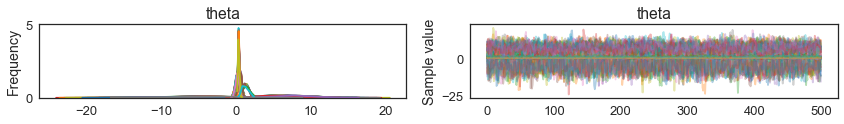

In [46]:
pm.traceplot(trace)

In [55]:
inferred_pol = HumanPolicy(np.r_[1, trace['theta'].mean(0)])
print(inferred_pol.theta)
print(results[0].theta)

[ 1.     5.809  7.666  0.545  0.164 -4.852  0.383  1.336]
[ 1.     5.     0.707  0.557  1.     0.627  0.32   1.   ]


In [50]:
pm.summary(trace)


theta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.809            2.569            0.043            [0.908, 11.017]
  7.666            2.891            0.043            [2.034, 13.265]
  0.545            0.231            0.004            [0.084, 0.988]
  0.164            0.257            0.004            [-0.336, 0.660]
  -4.852           4.695            0.071            [-13.914, 4.189]
  0.383            0.093            0.002            [0.215, 0.569]
  1.336            0.445            0.007            [0.485, 2.221]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.014          4.072          5.746          7.487          11.184
  2.226          5.709          7.568          9.600          13.605
  0.057          0.400          0.552          0.706          0.972
  -

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ac55c96d8>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f5ac55d4eb8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f5ac54fef98>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f5ac54e9a20>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f5ac5440a20>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f5ac542d470>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f5ac5383208>], dtype=object)

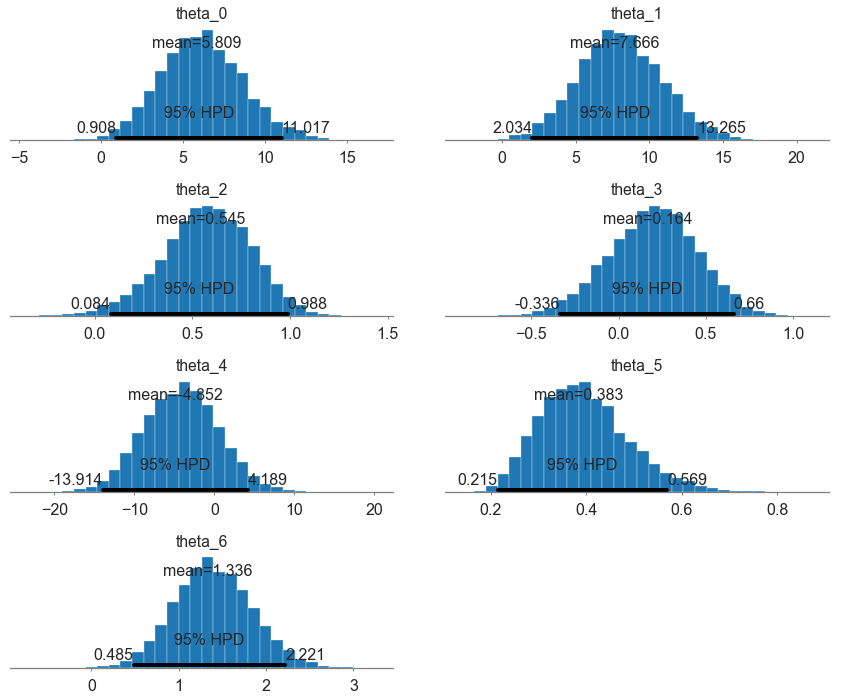

In [47]:
def var_df(var):
    panel = pd.Panel(trace[var], major_axis=info_costs, minor_axis=pr_types)
    frame = pd.melt(panel.to_frame().reset_index(),  id_vars=['major', 'minor'])
    frame = frame.rename(columns={'major': 'info_cost', 'minor': 'pr_type', 'variable': 'sample'})
    frame['var'] = var
    return frame

varnames = ['high', 'rate']
tdf = pd.concat(var_df(v) for v in varnames)

g = sns.FacetGrid(tdf, col='info_cost', row='var', hue='pr_type',
                  sharex=False, sharey=False, margin_titles=True)
g.map(sns.distplot, 'value', hist=False)
g.add_legend();

In [87]:
trace['theta'].std(0)

array([ 1.166,  0.452,  0.098,  0.09 ,  3.28 ,  0.109,  0.764])

In [88]:
pol.temp

0

In [86]:
ipol = HumanPolicnp.r_[1, trace['theta'].mean(0)]

array([ 1.   ,  1.893,  0.995, -0.267, -0.54 , -2.57 ,  0.844,  1.777])